# Homework 4

Download the dataset

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-08 14:01:02--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  1.25MB/s    in 1.1s    

2023-10-08 14:01:05 (1.25 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [29]:
import pandas as pd

data = pd.read_csv("./data.csv")
selected_columns = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP"
]
data = data.fillna(value={
    col: 0
    for col in selected_columns
})
data = data[selected_columns]
data.columns = data.columns.str.replace(' ', '_').str.lower()
data = data.rename(columns={"msrp": "price"})
selected_columns = data.columns.to_list()
data['above_average'] = data['price'].map(lambda x: 1 if x > data['price'].mean() else 0)
# data = data.fillna(0, )
data

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0
...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120,1
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670,1
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620,1
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920,1


In [30]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)


df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']


print(f"df train shape: {df_train.shape}")
print(f"df val shape: {df_val.shape}")
print(f"df test shape: {df_test.shape}")

df train shape: (7624, 10)
df val shape: (1907, 10)
df test shape: (2383, 10)


## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`


In [31]:
from sklearn.metrics import auc, roc_auc_score

col_to_inspect = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

for col in col_to_inspect:
    auc_val = roc_auc_score(y_train, df_train[col])
    if auc_val < 0.5:
        auc_val = roc_auc_score(y_train, -df_train[col])
    print(f"AUC val for col {col} is {auc_val}")

AUC val for col engine_hp is 0.9162324220917971
AUC val for col engine_cylinders is 0.7674408924408924
AUC val for col highway_mpg is 0.6351930621461872
AUC val for col city_mpg is 0.6754616043678544


The highest AUC value column is: `engine_hp`

## Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

sel_col = [col for col in selected_columns if col != 'price']

train_dict = df_train[sel_col].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[sel_col].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_score = model.predict_proba(X_val)[:, 1]


In [84]:
auc_val = round(roc_auc_score(y_val, y_score), 3)
print("The AUC val of trained model is: ", auc_val)

The AUC val of trained model is:  0.978


## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which **threshold** precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


In [85]:
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


df_scores = confusion_matrix_dataframe(y_val, y_score)
df_scores

,threshold,tp,fp,fn,tn
0,0.00,527,1380,0,0
1,0.01,525,656,2,724
2,0.02,524,525,3,855
3,0.03,524,471,3,909
4,0.04,523,426,4,954
...,...,...,...,...,...
96,0.96,207,1,320,1379
97,0.97,191,0,336,1380
98,0.98,175,0,352,1380
99,0.99,139,0,388,1380


In [86]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

[{'threshold': 0.5, 'tp': 464, 'fp': 62, 'fn': 63, 'tn': 1318, 'precision': 0.8821292775665399, 'recall': 0.8804554079696395, 'delta_pr': 0.0016738695969004125}, {'threshold': 0.49, 'tp': 464, 'fp': 62, 'fn': 63, 'tn': 1318, 'precision': 0.8821292775665399, 'recall': 0.8804554079696395, 'delta_pr': 0.0016738695969004125}, {'threshold': 0.48, 'tp': 466, 'fp': 63, 'fn': 61, 'tn': 1317, 'precision': 0.8809073724007561, 'recall': 0.8842504743833017, 'delta_pr': 0.0033431019825456154}]


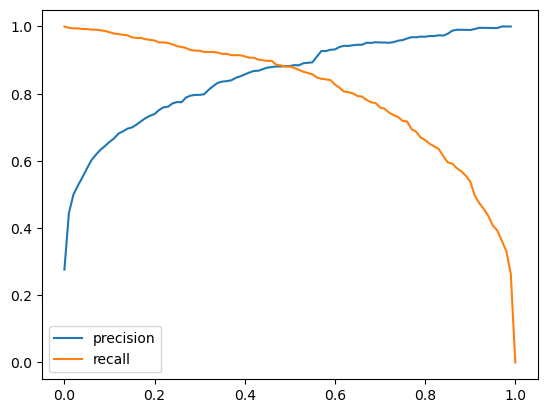

In [87]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')


df_scores['delta_pr'] = df_scores[['precision', 'recall']].apply(lambda x: abs(x['precision']- x['recall']), axis=1)

print(df_scores.sort_values(by='delta_pr').to_dict('records')[:3])

plt.legend()
plt.show()

The answer is in the threshold `0.48` the line intersect

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which **threshold** F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72


[{'threshold': 0.46, 'tp': 473, 'fp': 65, 'fn': 54, 'tn': 1315, 'precision': 0.879182156133829, 'recall': 0.8975332068311196, 'delta_pr': 0.018351050697290594, 'f1': 0.8882629107981221}, {'threshold': 0.45, 'tp': 473, 'fp': 66, 'fn': 54, 'tn': 1314, 'precision': 0.8775510204081632, 'recall': 0.8975332068311196, 'delta_pr': 0.01998218642295635, 'f1': 0.8874296435272044}, {'threshold': 0.42, 'tp': 478, 'fp': 73, 'fn': 49, 'tn': 1307, 'precision': 0.867513611615245, 'recall': 0.9070208728652751, 'delta_pr': 0.03950726125003012, 'f1': 0.8868274582560296}, {'threshold': 0.44, 'tp': 474, 'fp': 69, 'fn': 53, 'tn': 1311, 'precision': 0.8729281767955801, 'recall': 0.8994307400379506, 'delta_pr': 0.026502563242370547, 'f1': 0.8859813084112149}, {'threshold': 0.43, 'tp': 475, 'fp': 72, 'fn': 52, 'tn': 1308, 'precision': 0.8683729433272395, 'recall': 0.9013282732447818, 'delta_pr': 0.03295532991754235, 'f1': 0.8845437616387337}, {'threshold': 0.41000000000000003, 'tp': 478, 'fp': 76, 'fn': 49, 'tn

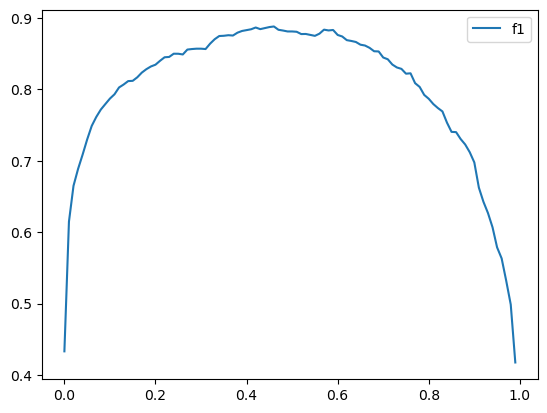

In [89]:
df_scores['f1'] = df_scores[['precision', 'recall']].apply(lambda x: 2 * ((x['precision'] * x['recall'] / (x['precision'] + x['recall']))), axis=1)
                       
print(df_scores.sort_values(by='f1', ascending=False).to_dict('records')[:10])

plt.plot(df_scores.threshold, df_scores['f1'], label='f1')
plt.legend()
plt.show()


The threshold that has a maximum F1 score is on the value: `0.52`

## Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [106]:

def train_and_predict(df_train, y_train, df_val, model_param = {"C":1.0}):
    dicts = df_train[sel_col].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', max_iter=1000, **model_param)
    model.fit(X_train, y_train)

    dicts = df_val[sel_col].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [107]:
from sklearn.model_selection import KFold

scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['above_average'].values
    y_val = df_val['above_average'].values

    y_pred = train_and_predict(df_train, y_train, df_val)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

scores

[0.9784891235596622,
 0.9809822645907552,
 0.9776211588868441,
 0.9772530812559255,
 0.9847777222777223]

In [108]:
print("The std_dev for the 5-kfold is", round(np.std(scores), 3))

The std_dev for the 5-kfold is 0.003


## Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

In [109]:
def k_fold_training_and_predict(df_full_train: pd.DataFrame, model_param = {"C": 1.0}):
    scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['above_average'].values
        y_val = df_val['above_average'].values

        y_pred = train_and_predict(df_train, y_train, df_val, model_param)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    return {
        "mean": np.mean(scores),
        "std": np.std(scores)
    }

for C in [0.01, 0.1, 0.5, 10]:
    res = k_fold_training_and_predict(df_full_train, model_param={"C": C})
    print(f"C={C} has a mean={round(res['mean'], 3)} and std={round(res['std'], 3)}")

C=0.01 has a mean=0.952 and std=0.002
C=0.1 has a mean=0.972 and std=0.002
C=0.5 has a mean=0.978 and std=0.001
C=10 has a mean=0.983 and std=0.003


The best mean is model with `C=10`